#  Анализ оттока клиентов банка

## Материалы
[Презентация](https://disk.yandex.ru/d/XTXeZSb102Df7Q)

[Дашборд](https://public.tableau.com/app/profile/ekaterina.pimenova/viz/_16820648273800/sheet12#2)

В банке "Метанпром" по непонятным причинам наблюдается критический отток клиентов. Отдел маркентинга хочет придумать программу лояльности для их удержания, поэтому главная **цель проекта - выделить сегменты пользователей, которые перестают пользоваться услугами банка**

**Описание данных**
- `USERID` — идентификатор пользователя
- `score` — баллы кредитного скоринга (показатель кредитоспосбности клиента)
- `сity` — город
- `gender` — пол
- `age` — возраст
- `equity`  — количество баллов собственности (некоторая оценка собственности клиента)
- `balance` — баланс на счёте
- `products` — количество продуктов, которыми пользуется клиент
- `сredit_сard` — есть ли кредитная карта:
    - 1 - есть кредитная карта
    - 0 - кредитной карты нет
- `last_activity` — активный клиент: 
    - 1 - клиент совершал какие-либо действия в последние 30 дней
    - 0 - клиент не совершал никаких действий в последние 30 дней 
- `EST_SALARY` — заработная плата клиента,
- `churn` — собирается ли клиент уйти:
  - 1 - клиент собирается уйти
  - 0 - клиент не собирается уходить

**План проекта**
1. [Загрузка данных и изучение общей информации](#start)
2. [Предобработка данных](#preprocessing)
    * [Изменение названий столбцов](#names)
    * [Обработка пропущенных значений](#null)
    * [Обработка дубликатов](#duplicates)
    * [Обработка типов данных](#types)
    * [Унитарное кодирование столбцов столбцов сity и gender](#unitary)
3. [Исследовательский анализ данных](#analysis)
    * [Изучение распределений и анализ выбросов](#distributions)
    * [Корреляции со стобцом churn](#churn)
    * [Категоризация данных](#categories)
    * [Портрет отточного клиента](#portret)
    * [Выводы](first_conclusions)
4. [Проверка гипотез](#hypotheses)
    * [Проверка первой гипотезы: различие дохода между теми клиентами, которые ушли и теми, которые остались](#first_hyp)
    * [Проверка второй гипотезы: различие в баллах скоринга между теми клиентами, которые ушли, и теми, которые остались](#second_hyp)
5. [Выводы о влиянии определенных признаков на отток клиентов](#mid_conclusions)
6. [Сегментация отточных клиентов](#segments)
    * [Выделение сегментов](#seg)
    * [Рекомендации](#recs)
7. [Общие выводы](#conclusions)

## Загрузка данных и изучение общей информации 
<a id="start"></a> 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats 
pd.options.mode.chained_assignment = None 
from plotly import graph_objects as go
import plotly.express as px


In [2]:
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
data = pd.read_csv(path)

In [3]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [5]:
initial_shape = data.shape
initial_shape

(10000, 12)

### Общая информация:
В данных 10000 строк, 12 столбцов. Заметим, что в некоторых столбцах данные неполные, есть пропуски. Сразу можно отметить, что в столбцах score и age данные не соответствуют типу int, хотя, кажется, числа в столбцах целые. Подробнее изучим этот факт на этапе предобработки.

## Предобрадотка данных
<a id="preprocessing"></a> 

### Изменение названий столбцов
<a id="names"></a> 

In [6]:
data = data.rename(columns = {'USERID':'user_id', 'EST_SALARY':'est_salary'})

In [7]:
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


### Обработка пропущенных значений
<a id="null"></a> 

In [8]:
data.isna().sum()

user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

In [15]:
print(f'Процент пропусков в столбце balance от всех данных {data["balance"].isna().sum()/data.shape[0]:.2%}')
print(f'Процент пропусков в столбце age от всех данных {data["age"].isna().sum()/data.shape[0]:.2%} ')

Процент пропусков в столбце balance от всех данных 22.95%
Процент пропусков в столбце age от всех данных 0.26% 


**Пропуски в столбце age занимают меньше процента, так что можем их удалить. Пропуски в столбце balance занимают около 23%, поэтому их удалять не будем. Заполнять медианой/средним тоже плохая идея, мы "размажем" какие-то отличительные особенности пользователей. В целом, в контексте нашей задачи, можно предположить, что пропуски появились из-за того, что пользователь перестал пользоваться услугами банка/проявляет маленькую активность/не пользуется продуктами и т.д, поэтому у нас нет информации о его балансе. Попробуем изучить этот вопрос**

In [116]:
# удаляю пропуски в столбце age
data = data.dropna(subset=['age']).reset_index(drop=True)
data.isna().sum()

user_id             0
score               0
city                0
gender              0
age                 0
equity              0
balance          2279
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

In [117]:
#посмотрим, связаны ли пропуски с оттоком клиентов
data.query('balance.isna()')['churn'].value_counts()

0    2266
1      13
Name: churn, dtype: int64

**Большинство клиентов с пропусками продолжают пользоваться услугами банка, поэтому предположение о том, что пропуск появился из-за того, что клиент ушел, не подтвердилось**

In [118]:
#посмотрим, связаны ли пропуски с количеством используемых продуктов
data.query('balance.isna()')['products'].value_counts()

1    1934
2     315
3      29
0       1
Name: products, dtype: int64

In [119]:
data['products'].describe()

count   9974.00
mean       1.87
std        0.79
min        0.00
25%        1.00
50%        2.00
75%        2.00
max        5.00
Name: products, dtype: float64

**Большинство клиентов (при рассмотрении всех пользователей) используют 1-2 продукта, пользователи с пропущенным балансом по большей части пользуются одним продуктом, явных закономерностей нет, хотя возможно эти пользователи пользуются какими-то услугами банка, но не заводят там карту**

In [120]:
# посмотрим, связаны ли пропуски с активностью пользователей  
data.query('balance.isna()')['last_activity'].value_counts()

1    1251
0    1028
Name: last_activity, dtype: int64

**Опять же, видим, что пропуски не свзяаны с малой активностью пользователей**

In [121]:
# связь пропусков с наличием кредитки
data.query('balance.isna()')['credit_card'].value_counts()

1    1858
0     421
Name: credit_card, dtype: int64

**Большая часть пропусков у тех людей, которые пользуются кредитными картами.Если значения в столбце - баланс дебетовой карты, то пропуск может означать, что дебетовый карты у клиента нет. Однако мы не можем быть в этом уверены, пропуски у клиентов с кредитными картами тоже есть.**

In [122]:
pd.set_option("display.float_format", "{:.2f}".format)
data['balance'].describe()

count        7695.00
mean       827245.59
std       1980327.41
min             0.00
25%        295698.71
50%        524295.33
75%        980051.21
max     119113552.01
Name: balance, dtype: float64

**Явной взаимосвязи пропусков в балансе с другими данными не выявлено.Принимаем решение оставить пропуски как есть.**

### Обработка дубликатов
<a id="duplicates"></a> 

In [123]:
data.duplicated().sum()
#явных дубликатов нет

0

In [124]:
data['user_id'].duplicated().sum()
# есть дубликаты в столбце user_id

50

In [125]:
data[['user_id','city', 'gender', 'age']].duplicated().sum()

0

**Несмотря на то, что есть дубликаты в user_id, нет пользователей с одним айди, городом и полом, значит, дубликаты - разные люди. Скорее всего дубликаты появились в результате технической ошибки.**

In [126]:
data.query('user_id.duplicated()').head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1582,190253,726.00,Ярославль,М,49.00,0,NaN,1,1,1,177700.78,0
1836,210662,896.00,Рыбинск,Ж,37.00,0,NaN,2,0,0,90916.04,0
2137,131419,739.00,Рыбинск,Ж,37.00,3,1307941.65,3,0,0,103867.47,0
2300,220816,934.00,Рыбинск,Ж,74.00,5,1294285.39,3,1,0,95606.80,0
2995,208081,821.00,Рыбинск,Ж,62.00,3,493608.26,2,1,1,33491.45,0


In [127]:
print(f'Процент дубликатов в столбце user_id от всех данных {round(100*data["user_id"].duplicated().sum()/data.shape[0],2)} %')

Процент дубликатов в столбце user_id от всех данных 0.5 %


**Дубликаты в user_id занимают меньше процента, поэтому можем их удалить**

In [128]:
data = data.drop_duplicates(subset=['user_id'])

**Проверим столбцы типа object на неявные дубликаты**

In [129]:
data['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

In [130]:
data['gender'].unique()

array(['Ж', 'М'], dtype=object)

**Все нормально: три города (Рыбинск, Ярославль и Ростов) и два пола (М и Ж)**

### Обработка типов данных
<a id="types"></a> 

**Преобразуем данные в стобцах score и age к целочисленному типу**

In [131]:
data['score'] = data['score'].astype('int64')
data['age'] = data['age'].astype('int64')

### Унитарное кодирование столбцов столбцов сity и gender
<a id="unitary"></a> 

In [132]:
data['city_copy'] = data['city']
data['gender_copy'] = data['gender']
data = pd.get_dummies(data, columns=['city_copy', 'gender_copy'], drop_first=False)
data = data.rename(columns=({'city_copy_Ростов':'rostov', 'city_copy_Ярославль':'yaroslavl', 'city_copy_Рыбинск':\
                   'rybinsk', 'gender_copy_Ж':'female', 'gender_copy_М':'male'}))
data

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,female,male
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9969,120553,814,Рыбинск,М,27,1,78144.65,1,0,1,18943.64,0,0,1,0,0,1
9970,139170,894,Ярославль,М,46,0,NaN,1,1,0,196898.29,0,0,0,1,0,1
9971,115639,903,Ярославль,М,24,0,NaN,2,1,1,108905.09,0,0,0,1,0,1
9972,148700,777,Ярославль,Ж,68,3,865457.97,3,0,1,86874.90,0,0,0,1,1,0


## Исследовательский анализ данных
<a id="analysis"></a> 


### Изучение распределений и анализ выбросов
<a id="distributions"></a> 

**Уточню, что выбросами я буду считать значения, которые лежат вне +- 1,5 * доверительный интервал**

#### Столбец score - баллы кредитного скоринга 

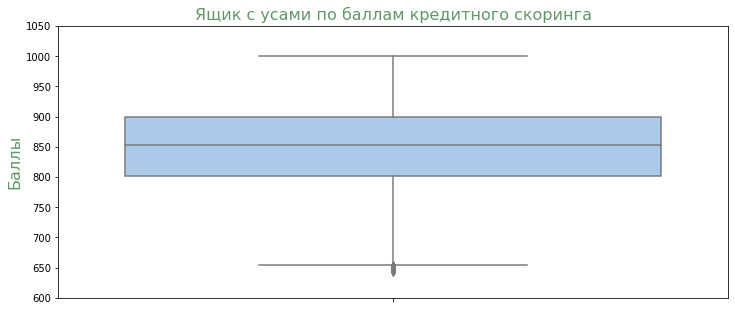

In [133]:
plt.figure(figsize=(12,5))
plt.ylim(600,1050)
sns.set_palette('pastel') 
sns.boxplot(y='score', data=data)
plt.title('Ящик с усами по баллам кредитного скоринга', fontsize = 16, color = '#609966')
plt.ylabel('Баллы', fontsize = 16, color = '#609966');

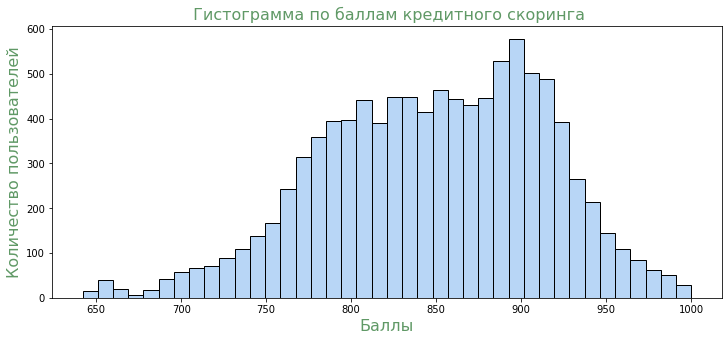

In [134]:
plt.figure(figsize=(12,5))
sns.set_palette('pastel') 
sns.histplot(x='score', data=data)
plt.title(' Гистограмма по баллам кредитного скоринга', fontsize = 16, color = '#609966')
plt.xlabel('Баллы', fontsize = 16, color = '#609966')
plt.ylabel('Количество пользователей', fontsize = 16, color = '#609966');

In [135]:
data['score'].describe()

count   9924.00
mean     848.73
std       65.40
min      642.00
25%      802.00
50%      853.00
75%      900.00
max     1000.00
Name: score, dtype: float64

In [136]:
len(data.query('score < 802-(900-802)*1.5'))
#считаю, что выбросы лежат вне +-1.5 доверительных интервала

33

**Если говорить про всех пользователей, то мы видим, что у большинства клиентов балл кредитного скоринга более 802 и менее 900. Медианное значение составляет 853, среднее - 849.Есть выбросы - 33 пользователя (не так много) с количеством баллов менее 655.**

In [137]:
data['churn'].value_counts()

0    8105
1    1819
Name: churn, dtype: int64

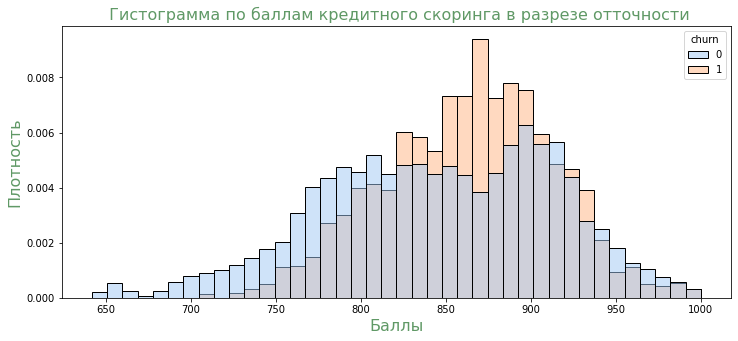

In [138]:
plt.figure(figsize=(12,5))
sns.histplot(x='score',hue='churn', stat='density', common_norm=False, data=data)
plt.title(' Гистограмма по баллам кредитного скоринга в разрезе отточности', fontsize = 16, color = '#609966')
plt.xlabel('Баллы', fontsize = 16, color = '#609966')
plt.ylabel('Плотность', fontsize = 16, color = '#609966');

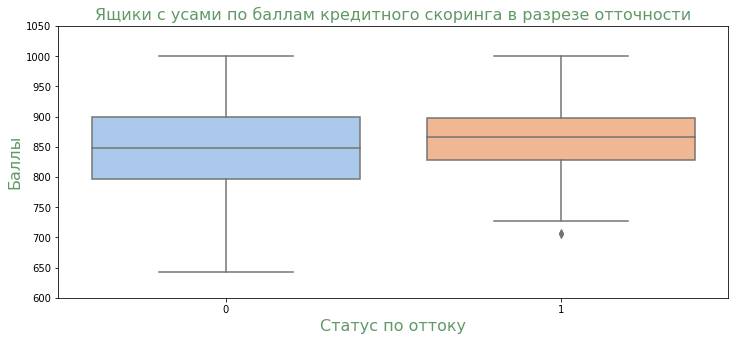

In [139]:
plt.figure(figsize=(12,5))
plt.ylim(600,1050) 
sns.boxplot(y='score', x = 'churn', data=data)
plt.title('Ящики с усами по баллам кредитного скоринга в разрезе отточности', fontsize = 16, color = '#609966')
plt.ylabel('Баллы', fontsize = 16, color = '#609966')
plt.xlabel('Статус по оттоку', fontsize = 16, color = '#609966');

In [140]:
data.query('churn == 1')['score'].describe()

count   1819.00
mean     863.42
std       49.62
min      706.00
25%      828.00
50%      866.00
75%      898.00
max     1000.00
Name: score, dtype: float64

In [141]:
data.query('churn == 0')['score'].describe()

count   8105.00
mean     845.44
std       68.01
min      642.00
25%      796.00
50%      848.00
75%      900.00
max     1000.00
Name: score, dtype: float64

In [142]:
data.query('churn == 1')['score'].describe()

count   1819.00
mean     863.42
std       49.62
min      706.00
25%      828.00
50%      866.00
75%      898.00
max     1000.00
Name: score, dtype: float64

In [143]:
len(data.query('churn == 1 and score < 723'))

2

**Отток пользователей с баллами скоринга 825-910 выше, чем в среднем по банку.**

#### Столбец balance - баланс карты

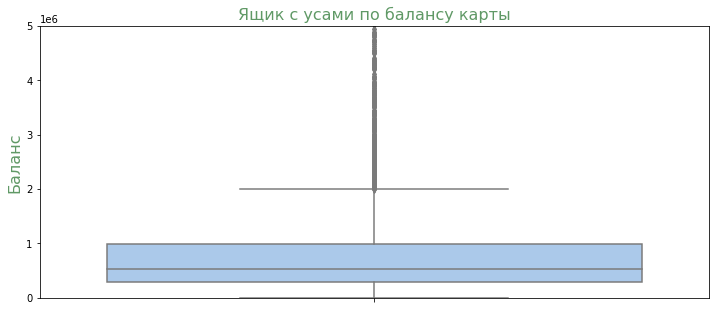

In [144]:
plt.figure(figsize=(12,5))
plt.ylim(0, 5000000)
sns.boxplot(y='balance', data=data)
plt.title('Ящик с усами по балансу карты', fontsize = 16, color = '#609966')
plt.ylabel('Баланс', fontsize = 16, color = '#609966');

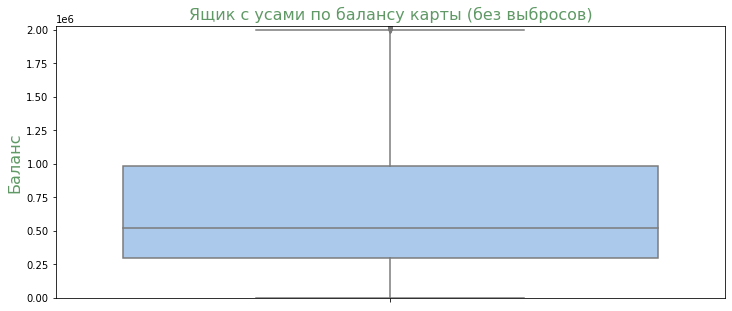

In [145]:
plt.figure(figsize=(12,5))
plt.ylim(0, 2030000)
sns.boxplot(y='balance', data=data)
plt.title('Ящик с усами по балансу карты (без выбросов)', fontsize = 16, color = '#609966')
plt.ylabel('Баланс', fontsize = 16, color = '#609966');

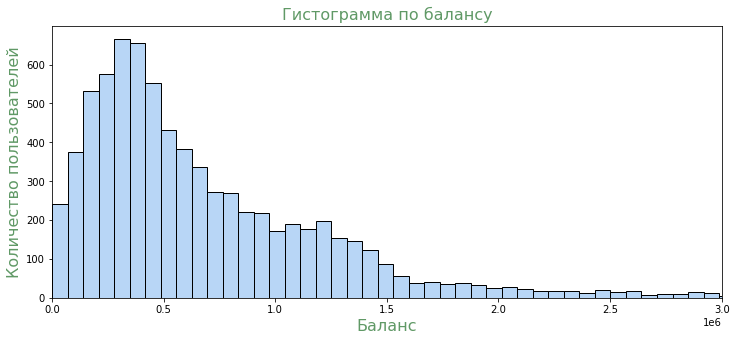

In [146]:
plt.figure(figsize=(12,5))
plt.xlim(0,3000000) 
sns.histplot(x='balance', data=data)
plt.title('Гистограмма по балансу', fontsize = 16, color = '#609966')
plt.xlabel('Баланс', fontsize = 16, color = '#609966')
plt.ylabel('Количество пользователей', fontsize = 16, color = '#609966');

In [147]:
data['balance'].describe()

count        7664.00
mean       828206.27
std       1984121.61
min             0.00
25%        295526.57
50%        524927.74
75%        980753.67
max     119113552.01
Name: balance, dtype: float64

In [148]:
len(data.query('balance > 2000000'))/len(data)

0.043027005239822655

In [149]:
data.query('balance < 2000000')['balance'].describe()

count      7237.00
mean     613818.36
std      431033.16
min           0.00
25%      286326.13
50%      488932.30
75%      872187.80
max     1999799.18
Name: balance, dtype: float64

**В глаза сразу бросаются аномальные суммы баланса на карте - свыше 2 млн.ед.Такие данные занимают 4% от всех, что достаточно много.В целом баланс большинства пользователей варьируется от 295526 до 980753 единиц**

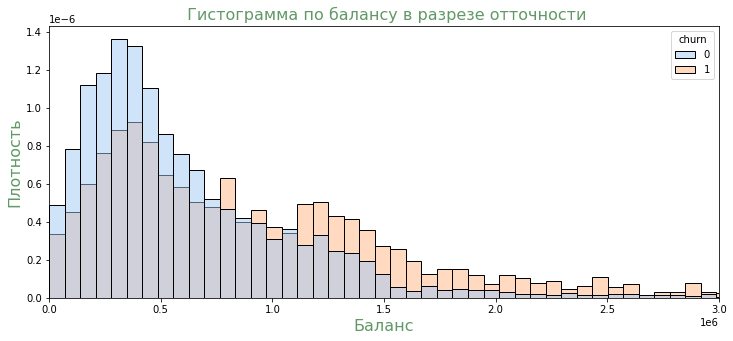

In [150]:
plt.figure(figsize=(12,5))
plt.xlim(0,3000000)
sns.histplot(x='balance',hue='churn', stat='density', common_norm=False, data=data)
plt.title(' Гистограмма по балансу в разрезе отточности', fontsize = 16, color = '#609966')
plt.xlabel('Баланс', fontsize = 16, color = '#609966')
plt.ylabel('Плотность', fontsize = 16, color = '#609966');

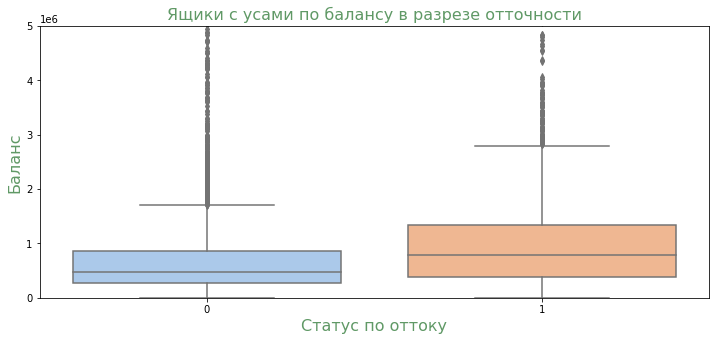

In [151]:
plt.figure(figsize=(12,5))
plt.ylim(0,5000000) 
sns.boxplot(y='balance', x = 'churn', data=data)
plt.title('Ящики с усами по балансу в разрезе отточности', fontsize = 16, color = '#609966')
plt.ylabel('Баланс', fontsize = 16, color = '#609966')
plt.xlabel('Статус по оттоку', fontsize = 16, color = '#609966');

In [152]:
data.query('churn == 0')['balance'].describe()

count        5858.00
mean       733789.92
std       1958890.42
min             0.00
25%        279013.32
50%        475382.45
75%        853815.30
max     119113552.01
Name: balance, dtype: float64

In [153]:
data.query('churn == 1')['balance'].describe()

count       1806.00
mean     1134458.21
std      2034445.55
min            6.00
25%       387482.16
50%       783908.90
75%      1348127.55
max     64866210.15
Name: balance, dtype: float64

**Отток пользователей с балансом выше 1250000 выше, чем в среднем по банку**

#### Столбец est_salary - заработная плата клиентов

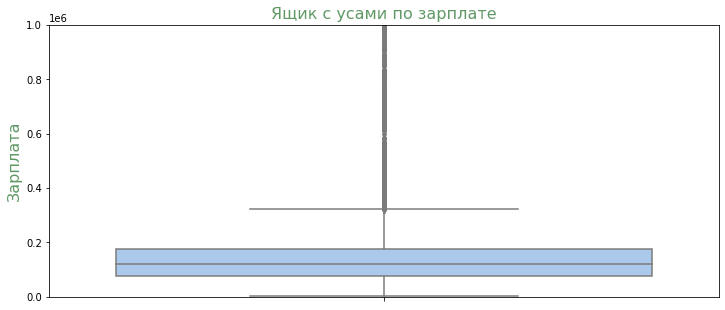

In [154]:
plt.figure(figsize=(12,5))
plt.ylim(0, 1000000)
sns.boxplot(y='est_salary', data=data)
plt.title('Ящик с усами по зарплате', fontsize = 16, color = '#609966')
plt.ylabel('Зарплата', fontsize = 16, color = '#609966');

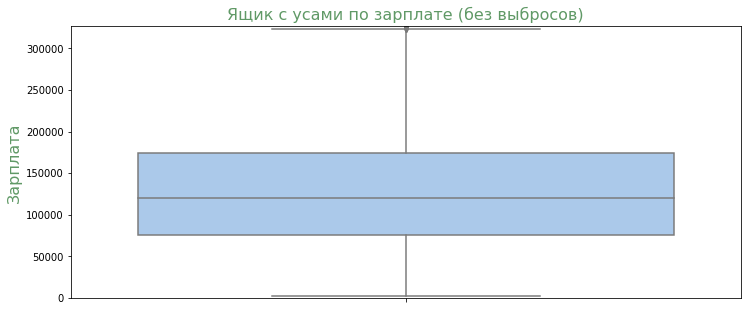

In [155]:
plt.figure(figsize=(12,5))
plt.ylim(0, 327000)
sns.boxplot(y='est_salary', data=data)
plt.title('Ящик с усами по зарплате (без выбросов)', fontsize = 16, color = '#609966')
plt.ylabel('Зарплата', fontsize = 16, color = '#609966');

In [156]:
data['est_salary'].describe()

count      9924.00
mean     147880.18
std      139358.30
min        2546.30
25%       75252.18
50%      119715.39
75%      174666.93
max     1395064.45
Name: est_salary, dtype: float64

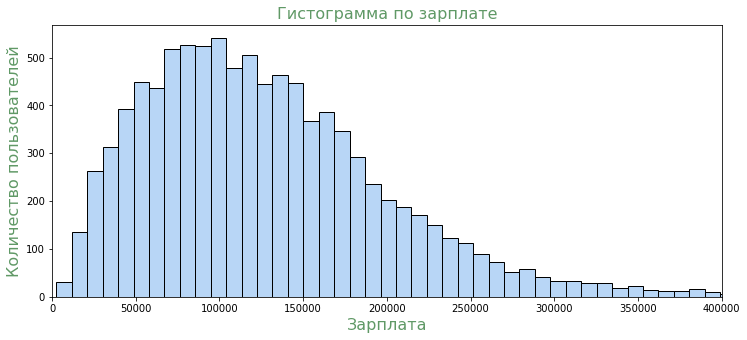

In [157]:
plt.figure(figsize=(12,5))
plt.xlim(0,400000) 
sns.histplot(x='est_salary', data=data)
plt.title('Гистограмма по зарплате', fontsize = 16, color = '#609966')
plt.xlabel('Зарплата', fontsize = 16, color = '#609966')
plt.ylabel('Количество пользователей', fontsize = 16, color = '#609966');

In [158]:
len(data.query('est_salary > 325000'))/len(data)

0.04746070133010883

**Большинство пользователей с зарплатой 75 - 175 тыс. единиц.Есть выбросы (составляют около 5% данных) - зарплаты свыше 325 тыс. ед.**

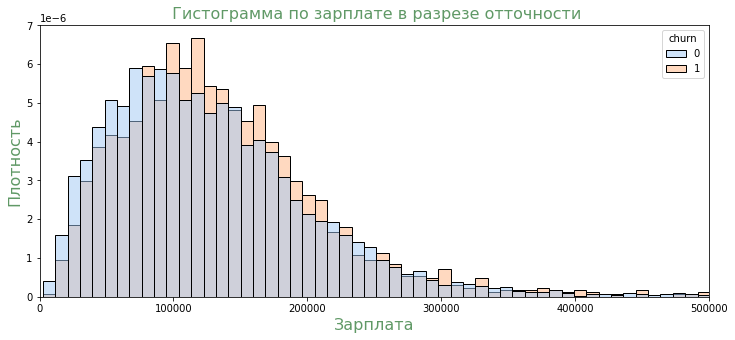

In [159]:
plt.figure(figsize=(12,5))
plt.xlim(0,500000)
sns.histplot(x='est_salary',hue='churn', stat='density', common_norm=False, data=data)
plt.title(' Гистограмма по зарплате в разрезе отточности', fontsize = 16, color = '#609966')
plt.xlabel('Зарплата', fontsize = 16, color = '#609966')
plt.ylabel('Плотность', fontsize = 16, color = '#609966');

In [160]:
data.query('churn == 0')['est_salary'].describe()

count      8105.00
mean     147788.27
std      142792.18
min        2546.30
25%       73489.66
50%      118247.25
75%      174087.83
max     1395064.45
Name: est_salary, dtype: float64

In [161]:
data.query('churn == 1')['est_salary'].describe()

count      1819.00
mean     148289.70
std      122932.16
min       10880.27
25%       83196.61
50%      125395.22
75%      175985.39
max     1263028.49
Name: est_salary, dtype: float64

**Отток пользователей с зарплатой 90000-210000 выше, чем в среднем по банку.**

#### Столбец age - возраст клиента

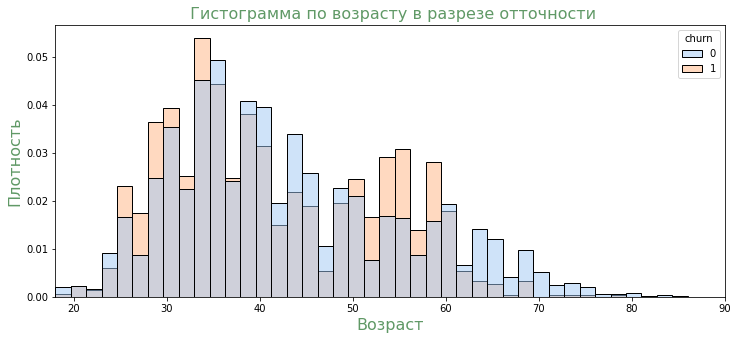

In [162]:
plt.figure(figsize=(12,5))
plt.xlim(18,90)
sns.histplot(x='age',hue='churn', stat='density', common_norm=False, data=data)
plt.title(' Гистограмма по возрасту в разрезе отточности', fontsize = 16, color = '#609966')
plt.xlabel('Возраст', fontsize = 16, color = '#609966')
plt.ylabel('Плотность', fontsize = 16, color = '#609966');

In [163]:
data['age'].describe()

count   9924.00
mean      42.73
std       12.18
min       18.00
25%       33.00
50%       40.00
75%       51.00
max       86.00
Name: age, dtype: float64

**Видим, что у клиентов в возрасте 23-35 и 50-59 лет уровень оттока выше, чем в среднем по банку.**

**Промежуточный вывод по гистограммам:**
- Отток пользователей с балансом выше 1250000 выше, чем в среднем по банку.
- Отток пользователей с зарплатой 900000-2100000 выше, чем в среднем по банку.
- Отток пользователей с баллами скоринга 825-910 выше, чем в с реднем по банку.
- Отток пользователей в возрасте 23-35 и 50-59 выше, чем в среднем по банку.

#### Столбец city - город пользователя

In [164]:
# расчитаем средний уровень оттока по банку 
bank_middle_churn = round(data['churn'].mean(), 2)
bank_middle_churn

0.18

In [165]:
data['city'].value_counts()

Ярославль    5854
Рыбинск      2654
Ростов       1416
Name: city, dtype: int64

In [166]:
city_churn = data.groupby('city', as_index = False).agg({'churn':'mean'}).sort_values(by='churn')
city_churn.columns= ['city', 'mean_churn']
city_churn

,city,mean_churn
1,Рыбинск,0.16
0,Ростов,0.19
2,Ярославль,0.19


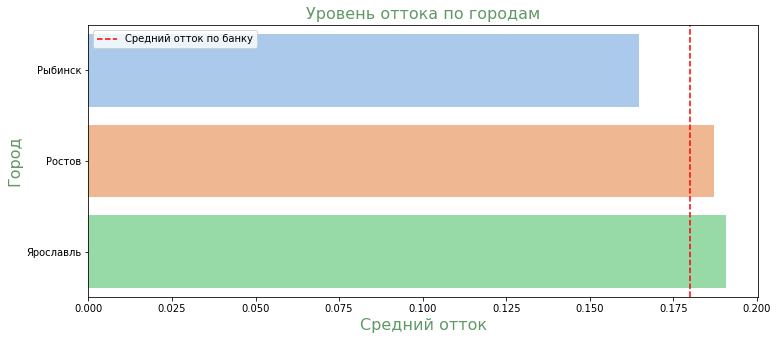

In [167]:
plt.figure(figsize = (12,5))
sns.barplot(data=city_churn, x='mean_churn', y='city')
plt.title('Уровень оттока по городам', fontsize = 16, color = '#609966')
plt.xlabel('Средний отток', fontsize = 16, color = '#609966')
plt.ylabel('Город', fontsize = 16, color = '#609966')
plt.axvline (x=bank_middle_churn, color='red', linestyle='--', label='Средний отток по банку')
plt.legend();


**Видим, что в Ростове и Ярославле отток пользователей выше, чем в среднем по банку.**

#### Столбец gender - пол пользователя

In [168]:
data['gender'].value_counts()

М    4971
Ж    4953
Name: gender, dtype: int64

In [169]:
gender_churn = data.groupby('gender', as_index = False).agg({'churn':'mean'}).sort_values(by='churn')
gender_churn.columns= ['gender', 'mean_churn']
gender_churn

,gender,mean_churn
0,Ж,0.13
1,М,0.24


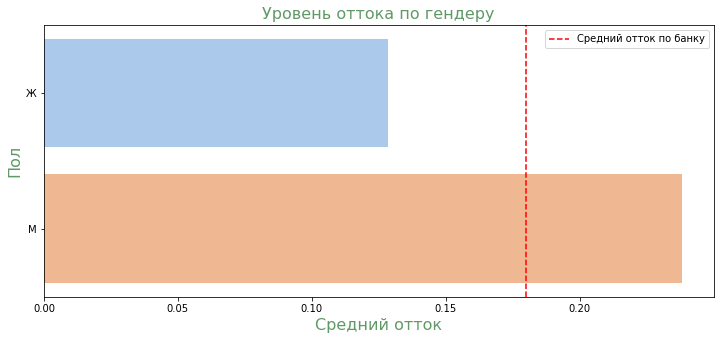

In [170]:
plt.figure(figsize = (12,5))
sns.barplot(data=gender_churn, x='mean_churn', y='gender')
plt.title('Уровень оттока по гендеру', fontsize = 16, color = '#609966')
plt.xlabel('Средний отток', fontsize = 16, color = '#609966')
plt.ylabel('Пол', fontsize = 16, color = '#609966')
plt.axvline (x=bank_middle_churn, color='red', linestyle='--', label ='Средний отток по банку')
plt.legend();

**Уровень оттока мужчин больше, чем в среднем по банку.**

In [171]:
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,female,male
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


#### Столбец equity - оценка недвижимости

In [172]:
data['equity'].value_counts()

0    2554
5    1910
4    1841
3    1532
2    1046
1     771
6     161
7      79
8      17
9      13
Name: equity, dtype: int64

**Клиентов с оценками выше 5 очень мало, поэтому мы не можем судить об их уровне оттока.**

In [173]:
equity_churn = data.groupby('equity', as_index = False).agg({'churn':'mean'}).sort_values(by='churn')
equity_churn.columns= ['equity', 'mean_churn']
equity_churn

,equity,mean_churn
0,0,0.04
1,1,0.12
2,2,0.16
3,3,0.21
4,4,0.25
5,5,0.30
8,8,0.35
6,6,0.36
7,7,0.47
9,9,0.54


**Несмотря на то, что клиенты с оценками выше 5 имеют уровень отточности выше среднего по банку, не будем делать о них выводы**

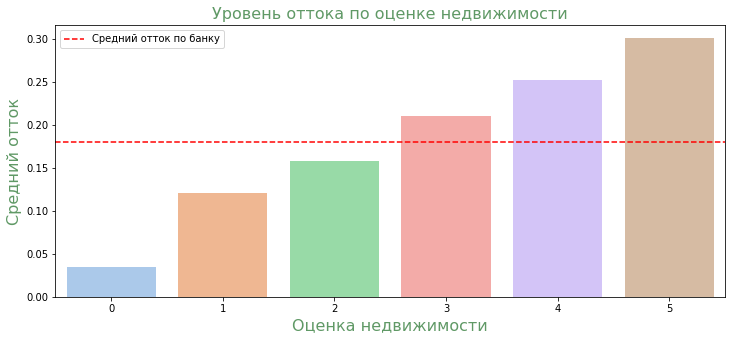

In [174]:
plt.figure(figsize = (12,5))
sns.barplot(data=equity_churn.query('equity < 6'), x='equity', y='mean_churn', order = list(equity_churn.query('equity < 6').sort_values(by='mean_churn')['equity']))
plt.title('Уровень оттока по оценке недвижимости', fontsize = 16, color = '#609966')
plt.xlabel('Оценка недвижимости', fontsize = 16, color = '#609966')
plt.ylabel('Средний отток', fontsize = 16, color = '#609966')
plt.axhline (y=bank_middle_churn, color='red', linestyle='--', label ='Средний отток по банку')
plt.legend();

**Видим, что уровень оттока у клиентов с оценкой недвижимости 3 и более выше среднего оттока по банку. Уточним, что оценок выше 5 совсем мало, поэтому мы не можем утверждать, что эти клиенты являются отточными.**


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️Хорошая идея - добавлять отметку о среднем уровне оттока на графики, есть с чем сравнивать</div>

#### Столбец products - количество используемых продуктов

In [175]:
data['products'].value_counts()

2    5095
1    3306
3    1029
4     474
5      19
0       1
Name: products, dtype: int64

**Не можем судить об уровне отточности клиентов, использующих 0 и 5 продуктов**

In [176]:
products_churn = data.groupby('products', as_index = False).agg({'churn':'mean'}).sort_values(by='churn')
products_churn.columns= ['products', 'mean_churn']
products_churn

,products,mean_churn
1,1,0.07
2,2,0.19
3,3,0.29
5,5,0.42
4,4,0.63
0,0,1.00


**Несмотря на то, что клиенты, использующие 0 и 5 продуктов, имеют уровень отточности выше среднего по банку, не будем делать о них выводы**

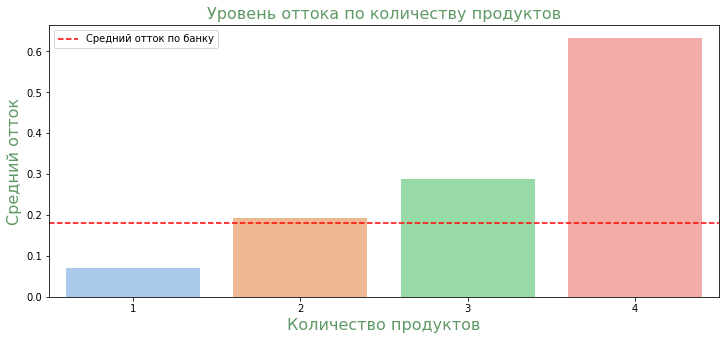

In [177]:
plt.figure(figsize = (12,5))
sns.barplot(data=products_churn.query('products != 0 and products!=5'), x='products', y='mean_churn')
plt.title('Уровень оттока по количеству продуктов', fontsize = 16, color = '#609966')
plt.xlabel('Количество продуктов', fontsize = 16, color = '#609966')
plt.ylabel('Средний отток', fontsize = 16, color = '#609966')
plt.axhline (y=bank_middle_churn, color='red', linestyle='--', label ='Средний отток по банку')
plt.legend();

**Уровень оттока клиентов, пользующихся двумя, тремя и четырьмя продуктами, выше среднего оттока по банку.Уточним, что уровень оттока пользователей 0 и 5 продуктов также выше банковского, но из-за маленького количества людей, делать выводы о них мы не можем.**

#### Столбец last_activity - активность клиента

In [178]:
data['last_activity'].value_counts()

1    5194
0    4730
Name: last_activity, dtype: int64

In [179]:
last_activity_churn = data.groupby('last_activity', as_index=False)[['churn']].mean().sort_values(by='churn')
last_activity_churn.columns = ['last_activity', 'mean_churn']
last_activity_churn

,last_activity,mean_churn
0,0,0.11
1,1,0.25


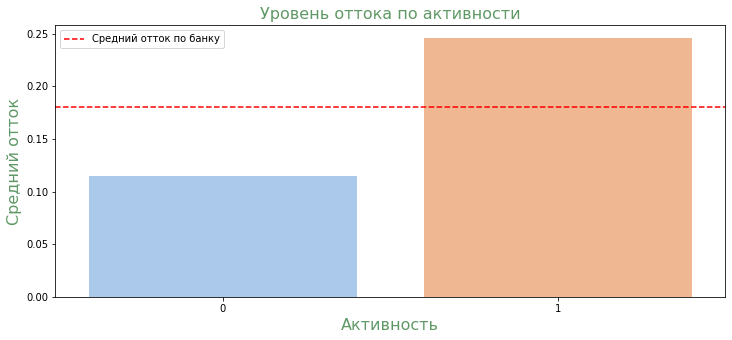

In [180]:
plt.figure(figsize = (12,5))
sns.barplot(data=last_activity_churn, x='last_activity', y='mean_churn')
plt.title('Уровень оттока по активности', fontsize = 16, color = '#609966')
plt.xlabel('Активность', fontsize = 16, color = '#609966')
plt.ylabel('Средний отток', fontsize = 16, color = '#609966')
plt.axhline (y=bank_middle_churn, color='red', linestyle='--', label ='Средний отток по банку')
plt.legend();

**Уровень оттока у пользователей, проявляющих активность, выше среднего по банку**

#### Столбец credit_card - наличие кредитной карты

In [181]:
data['credit_card'].value_counts()

1    6748
0    3176
Name: credit_card, dtype: int64

In [182]:
credit_card_churn = data.groupby('credit_card', as_index=False)[['churn']].mean().sort_values(by='churn')
credit_card_churn.columns = ['credit_card', 'mean_churn']
credit_card_churn

,credit_card,mean_churn
1,1,0.15
0,0,0.26


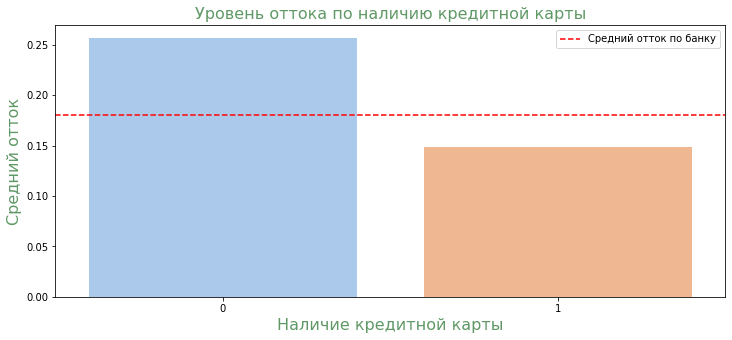

In [183]:
plt.figure(figsize = (12,5))
sns.barplot(data=credit_card_churn, x='credit_card', y='mean_churn')
plt.title('Уровень оттока по наличию кредитной карты', fontsize = 16, color = '#609966')
plt.xlabel('Наличие кредитной карты', fontsize = 16, color = '#609966')
plt.ylabel('Средний отток', fontsize = 16, color = '#609966')
plt.axhline (y=bank_middle_churn, color='red', linestyle='--', label ='Средний отток по банку')
plt.legend();

**У пользователей без кредитной карты отток выше, чем средний отток по банку**

#### Вывод:
В данных много выбросов : в столбцах зарплатой и балансом есть аномально большие значения, в столбце с оценкой уровня недвижимости малое количество людей получают оценки выше 6, в колонке products всего 20 пользователей, которые пользуются всеми продуктами и не пользуются ими вообще.
При рассмотрении распределений в разрезе оттока выяснилось:
- Отток пользователей с балансом выше 1250000 выше, чем в среднем по банку.
- Отток пользователей с зарплатой 90000-210000 выше, чем в среднем по банку.
- Отток пользователей с баллами скоринга 825-910 выше, чем в с реднем по банку.
- Отток пользователей в возрасте 23-35 и 50-59 выше, чем в среднем по банку.
- В Ростове и Ярославле отток пользователей выше, чем в среднем по банку
- Уровень оттока мужчин больше, чем в среднем по банку.
- Уровень оттока у клиентов с оценкой недвижимости, превышающей 3, выше среднего оттока по банку. Уточним, что оценок выше 5 совсем мало, поэтому мы не можем утверждать, что эти клиенты являются отточными
- Уровень оттока клиентов, пользующихся двумя, тремя и четырьмя продуктами, выше среднего оттока по банку.Уточним, что уровень оттока пользователей 0 и 5 продуктов также выше банковского, но из-за маленького количества людей, делать выводы о них мы не можем
- Уровень оттока у пользователей, проявляющих активность, выше среднего по банку
- Уровень оттока пользователей без кредитной карты выше среднего по банку


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️Полностью согласна с выводами, очень хороший анализ.</div>

### Корреляция со столбцом churn
<a id="churn"></a> 

In [184]:
data

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,female,male
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9969,120553,814,Рыбинск,М,27,1,78144.65,1,0,1,18943.64,0,0,1,0,0,1
9970,139170,894,Ярославль,М,46,0,NaN,1,1,0,196898.29,0,0,0,1,0,1
9971,115639,903,Ярославль,М,24,0,NaN,2,1,1,108905.09,0,0,0,1,0,1
9972,148700,777,Ярославль,Ж,68,3,865457.97,3,0,1,86874.90,0,0,0,1,1,0


In [185]:
data_corr =data[['score','equity','balance', 'age','products','credit_card', 'last_activity','est_salary','churn','rostov','rybinsk', 'yaroslavl','female', 'male']]

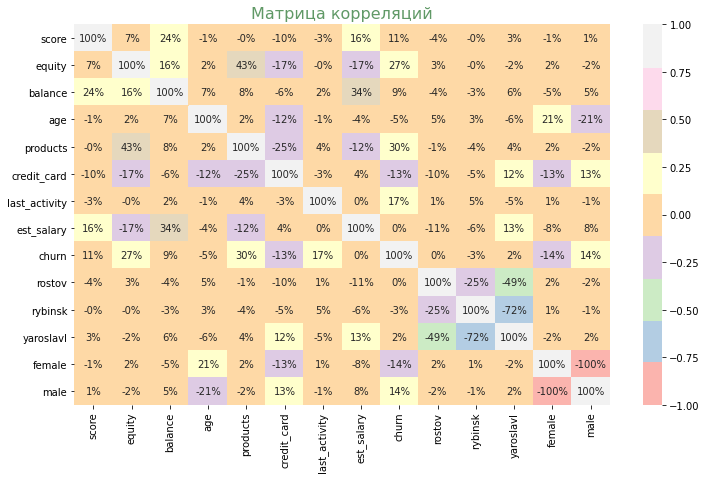

In [186]:
plt.figure(figsize=(12,7))
sns.heatmap(data_corr.corr(), annot=True, cmap='Pastel1', fmt='.0%', center=0)
plt.title('Матрица корреляций', fontsize = 16, color = '#609966');

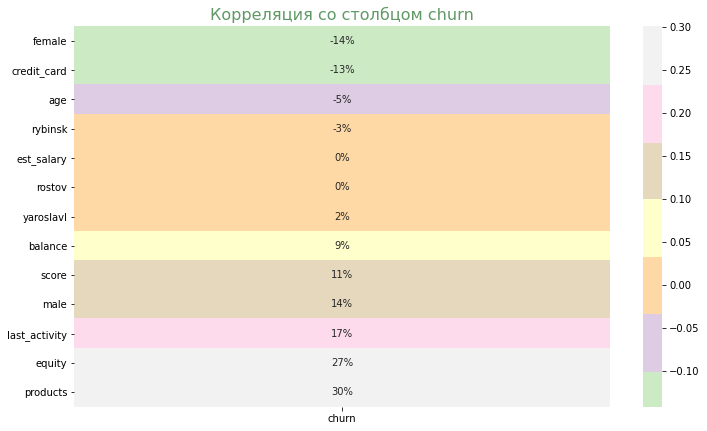

In [187]:
plt.figure(figsize=(12,7))
sns.heatmap(data_corr.corr().loc[:,['churn']].drop('churn').sort_values(by='churn'), annot=True, cmap='Pastel1', fmt='.0%', center=0)
plt.title('Корреляция со столбцом churn', fontsize = 16, color = '#609966');

**Видим, что самая большая взаимосвязь оттока выявлена с количеством продуктов и уровнем зарплаты (зависимость положительная). Также относительно высокие показатели коэффициента корреляции между оттоком и активностью, полом (с мужским свзяь положительная, с женским - отрицательная), скорингом и наличием кредитной карты (отрицательная взаимосвязь). Отметим, что коэффициенты корреляции небольшие в привычном понимании, однако выбивающиеся значения могут помочь нам уловить взаимосвязи. Так, например, подтвердились наши выводы о том, что:**
- Пользователи с высокой зарплатой уходят с большей вероятностью;
- Пользователи с большим количеством продуктов уходят чаще;
- Активные пользователи и пользователи без кредитной карты больше подвержены оттоку;
- Мужчины уходят из банка чаще женщин;

### Категоризация данных
<a id="categroies"></a> 


**У нас уже есть определенное представление об отточных клиентах, попробуем разбить пользователей на категории в соответсвии с распределениями**

#### Категоризация по кредитному скорингу

Мы вяснили, что отток пользователей с баллами скоринга 825-900 выше, чем в среднем по банку.
Разобьем пользователей на категории по скорингу следующим образом:
- ниже 825
- 825-900
- выше 900

In [188]:
def score_category(score):
    if score <= 825:
        return 'ниже 825'
    elif score >= 900:
        return 'выше 900'
    else:
        return '825-900'
    

In [189]:
data['score_category'] = data['score'].apply(score_category)

#### Категоризация по балансу

Среди уходящих пользователей больше клиентов с высоким балансом.Также в этом столбце есть выбросы - балансы больше 2 млн.ед. Аномальные значения и пропуски внесем в отдельную категорию. Разобьем пользователей на категории по балансу следующим образом.:
- меньше миллиона 
- 1 - 2 миллиона
- аномально большой баланс/пропуск

In [190]:
def balance_category(balance):
    if balance > 1000000 and balance < 2000000:
        return '1 - 2 миллиона'
    elif balance < 1000000:
        return 'меньше миллиона'
    else:
        return 'аномально большой баланс/пропуск'

In [191]:
data['balance_category'] = data['balance'].apply(balance_category)
data

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,female,male,score_category,balance_category
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,825-900,меньше миллиона
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,825-900,меньше миллиона
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0,825-900,аномально большой баланс/пропуск
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0,825-900,1 - 2 миллиона
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1,ниже 825,меньше миллиона
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9969,120553,814,Рыбинск,М,27,1,78144.65,1,0,1,18943.64,0,0,1,0,0,1,ниже 825,меньше миллиона
9970,139170,894,Ярославль,М,46,0,NaN,1,1,0,196898.29,0,0,0,1,0,1,825-900,аномально большой баланс/пропуск
9971,115639,903,Ярославль,М,24,0,NaN,2,1,1,108905.09,0,0,0,1,0,1,выше 900,аномально большой баланс/пропуск
9972,148700,777,Ярославль,Ж,68,3,865457.97,3,0,1,86874.90,0,0,0,1,1,0,ниже 825,меньше миллиона


#### Категоризация по зарплате

Отток пользователей с зарплатой 90000-210000 выше, чем в среднем по банку. В данных есть выбросы - зарплаты выше 325 тыс., их внесем в отдельную категорию. Разобьем пользователей на категории следующим образом:
- меньше 90 тыс.
- 90 тыс. - 210 тыс.
- 210 тыс. - 325 тыс.
- аномально большая зарплата

In [192]:
def salary_category(est_salary):
    if est_salary > 90000 and est_salary <= 210000:
        return '90 тыс. - 210 тыс.'
    elif est_salary > 210000 and est_salary <= 325000:
        return '210 тыс. - 325 тыс.'
    elif est_salary <= 90000 :
        return 'меньше 90 тыс.'
    else:
        return 'аномально большая зарплата'

In [193]:
data['salary_category'] = data['est_salary'].apply(salary_category)

#### Категоризация по возрасту

У клиентов в возрасте 23-35 и 50-59 лет уровень оттока выше, чем в среднем по банку. Людей старше 75 в нашем банке мало, их вынесем в отдельную категорию. Разобьем пользователей на категории по возрасту следующим образом:
-  18-22
-  23-35 
-  36-49
-  50-59
-  60-75
-  больше 75

In [194]:
def age_category(age):
    if age <= 22:
        return '18-22'
    elif age >= 23 and age <= 35:
        return '23-35'
    elif age >= 36 and age <= 49:
        return '36-49'
    elif age >= 50 and age <= 59:
        return '50-59'
    elif age >= 60 and age <= 75:
        return '60-75'
    else:
        return 'больше 75'

In [195]:
data['age_category'] = data['age'].apply(age_category)

### Портрет отточного клиента
<a id="portret"></a> 

Итак, мы сформировали некоторые признаки клиентов, подверженных оттоку:
- **Пол: мужской**
- **Зарплата: 90 тыс. - 210 тыс.**
- **Без кредитной карты**
- **Количество продуктов: 2 и больше**
- **Есть активность**
- **с баллами кредитного скоринга 825-900**
Эти характеристики подтвердились при сравнении средней отточности со средней по банку и при корреляционном анализе.
Высоким средним оттоком, но небольшим коэффициентом корреляции с churn обладают пользователи:

- **С балансом 1 - 2 млн.**
- **23-35 и 50-59 лет**
- **из Ярославля и Ростова**
- **с оценкой недвижимости 3 и более**

In [196]:
#объединим пользователей по первым 5 признакам и посмотрим на средний отток
#portret = data.query('male == 1 and salary_category == "90 тыс. - 210 тыс." and credit_card == 0 and\
           # products >= 2 and last_activity ==1')
#if portret['churn'].sum()/len(portret) > bank_middle_churn:
    #print('Отток по портрету выше среднебанковского и равен', round(portret['churn'].sum()/len(portret), 2) )
    #else:
        #print('Отток по портрету ниже среднебанковского')

## Проверка гипотез 
<a id="hypotheses"></a>

### Проверка первой гипотезы: различие дохода между теми клиентами, которые ушли и теми, которые остались
<a id="first_hyp"></a>


Рассмотрим подробнее распределение зарплат клиентов

In [197]:
np.percentile(data['est_salary'], [90, 95, 99])

array([242286.407 , 316818.7965, 887381.7149])

Не более 5 процентов клиентов имеют зарплату более 316818 ед., не более 1 процента - 887381

Для того, чтобы определить критерий проверки гипотезы, нам необходимо глубже проанализировать распределение. Мы уже знаем, что в данных есть выбросы, это может повлиять на количественные переменные. Проверим, является ли распределение зарплат нормальным при помощи теста Шапиро-Уилка. Для данного теста при больших выборках (больше 5000) рекомендуется брать уровень статистической значимости 0.05:

- H_0: зарплата распределена по нормальному закону
- H_1: распределение зарплаты не подчиняется нормальному закону



In [198]:
alpha = 0.05  
results = stats.shapiro(data['est_salary'])
p_value = results[1] 
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 
    

Отвергаем нулевую гипотезу: распределение не нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


**Так как мы анализируем количественные переменные, на результат могут повлиять выбросы. Распределение не подчиняется нормальному закону, выбросы сдвигают параметрические результаты, поэтому параметрические критерии нам не подходят. В связи с этим, будем использовать непараметрический тест Манна - Уитни, который оценивает не сами значения, а их ранги. Для избежания ошибки первого рода (ложнопозитивного результата) возьмем статистический уровень значимости 0.01**
- **H_0: Различий между доходами отточных и неотточных пользователей нет**
- **H_1: Есть различия между доходами отточных и неотточных пользователей**

#### Проверка гипотезы по сырым данным:

In [199]:
alpha = 0.01
results = stats.mannwhitneyu(data.query('churn ==1')['est_salary'], data.query('churn == 0')['est_salary'])
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, есть статистически значимое различие в  доходе отточных и неотточных клиентов')
else:
    print('Нет статистически значимого различия в доходе отточных и неотточных клиентов')

Отвергаем нулевую гипотезу, есть статистически значимое различие в  доходе отточных и неотточных клиентов


#### Проверка гипотезы по очищенным данным

Уберем выбросы и посмотрим на результат проверки гипотезы без них

In [200]:
alpha = 0.01
results = stats.mannwhitneyu(data.query('churn ==1 and est_salary < 316818.7965 ')['est_salary'], data.query('churn == 0 and est_salary < 316818.7965')['est_salary'])
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, есть статистически значимое различие в доходе отточных и неотточных клиентов')
else:
    print('Нет статистически значимого различия в доходе отточных и неотточных клиентов')

Отвергаем нулевую гипотезу, есть статистически значимое различие в доходе отточных и неотточных клиентов


In [201]:
print('Абсолютные потери:', len(data.query('est_salary > 316818.7965')))
print('Относительные потери:', round(len(data.query('est_salary > 316818.7965'))/len(data), 2))

Абсолютные потери: 497
Относительные потери: 0.05


**Итак, по сырым и очищенным от выбросов данным получили один результат: есть статистически значимое различие между доходами отточных и остающихся клиентов**

### Проверка второй гипотезы: различие в баллах скоринга между теми клиентами, которые ушли, и теми, которые остались
<a id="second_hyp"></a>

Рассмотрим подробнее распределение в баллах скоринга пользователей

In [202]:
np.percentile(data['score'], [90, 95, 99])

array([928., 946., 978.])

Не более 5% пользователей имеют балл выше 946, не более 1% - выше 978

Для того, чтобы определить критерий проверки гипотезы, нам необходимо глубже проанализировать распределение. Мы уже знаем, что в данных есть выбросы, это может повлиять на количественные переменные. Проверим, является ли распределение баллов скоринга нормальным при помощи теста Шапиро-Уилка. Для данного теста при больших выборках (больше 5000) рекомендуется брать уровень статистической значимости 0.05:

- H_0: баллы скоринга распределены по нормальному закону
- H_1: распределение баллов скоринга не подчиняется нормальному закону

In [203]:
alpha = 0.05 
results = stats.shapiro(data['score'])
p_value = results[1] 
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

Отвергаем нулевую гипотезу: распределение не нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


**Так как мы анализируем количественные переменные, на результат могут повлиять выбросы. Распределение не подчиняется нормальному закону, выбросы сдвигают параметрические результаты, поэтому параметрические критерии нам не подходят. В связи с этим, будем использовать непараметрический тест Манна - Уитни, который оценивает не сами значения, а их ранги. Для избежания ошибки первого рода (ложнопозитивного результата) возьмем статистический уровень значимости 0.01**
- **H_0: Различий между баллами сокринга отточных и неотточных пользователей нет**
- **H_1: Есть различия между баллами скоринга отточных и неотточных пользователей**

#### Проверка гипотезы по сырым данным

In [204]:
alpha = 0.01
results = stats.mannwhitneyu(data.query('churn ==1')['score'], data.query('churn == 0')['score'])
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, есть статистически значимое различие в баллах скоринга отточных и неотточных клиентов')
else:
    print('Нет статистически значимого различия в баллах скоринга отточных и неотточных клиентов')

Отвергаем нулевую гипотезу, есть статистически значимое различие в баллах скоринга отточных и неотточных клиентов


#### Проверка гипотезы по очищенным данным

In [205]:
alpha = 0.01
results = stats.mannwhitneyu(data.query('churn ==1 and score < 946.0')['score'], data.query('churn == 0 and score < 946.0')['score'])
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, есть статистически значимое различие в баллах скоринга отточных и неотточных клиентов')
else:
    print('Нет статистически значимого различия в баллах скоринга отточных и неотточных клиентов')

Отвергаем нулевую гипотезу, есть статистически значимое различие в баллах скоринга отточных и неотточных клиентов


In [206]:
print('Абсолютные потери:', len(data.query(' score > 946.0')))
print('Относительные потери:', round(len(data.query('score > 946.0'))/len(data), 2))

Абсолютные потери: 482
Относительные потери: 0.05


**При проверке гипотезы по сырым и очищенным данным получили один и тот же результат: есть статистически значимое различие в баллах скоринга отточных и неотточных клиентов**

### Выводы о влиянии определенных признаков на отток клиентов
<a id="mid_conclusions"></a>


При исследовательском анализе нами были замечены некоторые взаимосвязи данных о клиентах и их отточном статусе. При сравнении среднего оттока в разбивке по различным признакам и среднего оттока по банку выяснилось, что:
- Отток пользователей с балансом выше 1250000 выше, чем в среднем по банку.
- Отток пользователей с зарплатой 90000-210000 выше, чем в среднем по банку.
- Отток пользователей с баллами скоринга 825-900 выше, чем в с реднем по банку.
- Отток пользователей в возрасте 23-35 и 50-59 выше, чем в среднем по банку.
- В Ростове и Ярославле отток пользователей выше, чем в среднем по банку
- Уровень оттока мужчин больше, чем в среднем по банку.
- Уровень оттока у клиентов с оценкой недвижимости, превышающей 3, выше среднего оттока по банку. Уточним, что оценок выше 5 совсем мало, поэтому мы не можем утверждать, что эти клиенты являются отточными
- Уровень оттока клиентов, пользующихся двумя, тремя и четырьмя продуктами, выше среднего оттока по банку.Уточним, что уровень оттока пользователей 0 и 5 продуктов также выше банковского, но из-за маленького количества людей, делать выводы о них мы не можем
- Уровень оттока у пользователей, проявляющих активность, выше среднего по банку
- Уровень оттока пользователей без кредитной карты выше среднего по банку
Далее мы провели корреляционный анализ, в ходе которого выявились взаимосвязи неоторых признаков с отточностью пользователей: самая большая взаимосвязь оттока выявлена с количеством продуктов и уровнем зарплаты (зависимость положительная). Также относительно высокие показатели коэффициента корреляции между оттоком и активностью, полом (с мужским свзяь положительная, с женским - отрицательная) и наличием кредитной карты (отрицательная взаимосвязь)
Благодаря вышеперечисленным заключениям нам удалось сделать следующие выводы по характеристикам уходящего клиента:
- **Пол: мужской**
- **Зарплата: 90 тыс. - 210 тыс.**
- **Без кредитной карты**
- **C баллами кредитного скоринга 825-900**
- **Количество продуктов: 2 и больше**
- **Есть активность**

Эти характеристики подтвердились при сравнении средней отточности со средней по банку и при корреляционном анализе.
Высоким средним оттоком, но небольшим коэффициентом корреляции с churn обладают пользователи:

- **С балансом 1 - 2 млн.**
- **23-35 и 50-59 лет**
- **из Ярославля и Ростова**
- **с оценкой недвижимости 3 и более**

После проверки гипотез о доходах и кредитном скоринге клиентов, выяснилось, что между уходящими и остающимися пользователями есть статистически значимые различия по этим признакам.

## Сегментация отточных клиентов
<a id="segments"></a>

### Выделение сегментов
<a id="seg"></a>

#### Первый сегмент


- **Пол: мужской**
- **Зарплата: 90 тыс. - 210 тыс.**
- **Без кредитной карты**


In [207]:
first_segment = data.query('male == 1 and salary_category == "90 тыс. - 210 тыс." and credit_card == 0')
if first_segment['churn'].sum()/len(first_segment) > bank_middle_churn:
    print('Отток по сегменту выше среднебанковского и равен', round(first_segment['churn'].sum()/len(first_segment), 2) )
    print('Размер сегмента:', len(first_segment))
    print('Количество отточных клиентов:', first_segment['churn'].sum())
else:
    print('Отток по сегменту ниже среднебанковского')

Отток по сегменту выше среднебанковского и равен 0.39
Размер сегмента: 673
Количество отточных клиентов: 263


#### Второй сегмент
- **Баллы кредитного скоринга 825-900**
- **Возраст: 23-35** 
- **Активность: есть**

In [208]:
second_segment = data.query('score_category == "825-900" and age_category == "23-35" and last_activity == 1')
if second_segment['churn'].sum()/len(second_segment) > bank_middle_churn:
    print('Отток по  выше среднебанковского и равен', round(second_segment['churn'].sum()/len(second_segment), 2) )
    print('Размер сегмента', len(second_segment))
    print('Количество отточных клиентов:', second_segment['churn'].sum())
else:
    print('Отток по сегменту ниже среднебанковского')

Отток по  выше среднебанковского и равен 0.46
Размер сегмента 689
Количество отточных клиентов: 318


#### Третий сегмент

- **Количество продуктов: 2 и более**
- **Кредитная карта: нет**
- **Баллы кредитного скоринга: 825-900**
- **Активность: есть**



In [209]:
third_segment = data.query('products >= 2 and credit_card == 0 and last_activity == 1 and score_category == "825-900"')
if third_segment['churn'].sum()/len(third_segment) > bank_middle_churn:
    print('Отток по сегменту выше среднебанковского и равен', round(third_segment['churn'].sum()/len(third_segment), 2) )
    print('Размер сегмента', len(third_segment))
    print('Количество отточных клиентов:', third_segment['churn'].sum())
else:
    print('Отток по сегменту ниже среднебанковского')

Отток по сегменту выше среднебанковского и равен 0.54
Размер сегмента 693
Количество отточных клиентов: 372


In [210]:
third_segment.groupby('churn', as_index=False).agg({'user_id':'count'})

,churn,user_id
0,0,321
1,1,372


#### Четвертый сегмент

- **Оценка недвижимости: 3 и более**
- **Город: Ярославль**
- **Количество продуктов: 2 и более**
- **Активность: есть**

In [211]:
fourth_segment = data.query('equity >= 3 and yaroslavl==1 and products >= 2 and last_activity == 1')
if fourth_segment['churn'].sum()/len(fourth_segment) > bank_middle_churn:
    print('Отток по сегменту выше среднебанковского и равен', round(fourth_segment['churn'].sum()/len(fourth_segment), 2) )
    print('Размер сегмента', len(fourth_segment))
    print('Количество отточных клиентов:', fourth_segment['churn'].sum())
else:
    print('Отток по сегменту ниже среднебанковского')

Отток по сегменту выше среднебанковского и равен 0.43
Размер сегмента 1394
Количество отточных клиентов: 596


#### Пятый сегмент

- **Баланс: 1 - 2 миллиона**
- **Количество продуктов: 2 и более**

In [212]:
fifth_segment = data.query('balance_category == "1 - 2 миллиона" and products >= 2 ')
if fifth_segment['churn'].sum()/len(fifth_segment) > bank_middle_churn:
    print('Отток по сегменту выше среднебанковского и равен', round(fifth_segment['churn'].sum()/len(fifth_segment), 2) )
    print('Размер сегмента', len(fifth_segment))
    print('Количество отточных клиентов:', fifth_segment['churn'].sum())
else:
    print('Отток по сегменту ниже среднебанковского')

Отток по сегменту выше среднебанковского и равен 0.38
Размер сегмента 1279
Количество отточных клиентов: 484


### Приоритезация сегментов

Предпочтильнее начинать с рассмотрения небольших сегментов, так как отделу маркетинга будет проще придумать для них программу лояльности. Сегменты 4 и 5 сильно увеличат количество работы маркетологов, поэтому их скорее стоит рассматривать как дополнительные.
1. Третий сегмент -  уровень отточности 0.54 , небольшой размер 
2. Второй сегмент - уровень отточности 0.46, небольшой размер
3. Первый сегмент - уровень отточности 0.39, небольшой размер
4. Четвертый сегмент - уровень отточности 0.43, средний размер
5. Пятый сегмент - уровень отточности 0.38, средний размер

### Рекомендации по сегментам
<a id="recs"></a>


- **Третий сегмент** - *приоритет 1*
    - **Количество продуктов: 2 и более**
    - **Кредитная карта: нет**
    - **Баллы кредитного скоринга: 825-900**
    - **Активность: есть**
        - Отток по сегменту выше среднебанковского и равен 0.54
        - Размер сегмента 693
        - Количество отточных клиентов: 372
        
**Рекомендации**: в данном сегменте находятся пользователи с высоким баллом кредитного скоринга и без кредитной карты, при этом они являются активными и пользуются нашими продуктами.Возможно есть какая-то причина, по которым пользователи не хотят открывать кредитку в нашем банке. Можно предложить им завести карту с бесплатным обслуживанием / большим лимитом / бонусами.
- **Второй сегмент** - *приоритет 2*
    - **Баллы кредитного скоринга 825-900**
    - **Возраст: 23-35** 
    - **Активность: есть**
        - Отток по  выше среднебанковского и равен 0.46
        - Размер сегмента 689
        - Количество отточных клиентов: 318
        
**Рекомендации**: здесь мы видим активных пользователей возраста 23-35 с высоким баллом кредитного скоринга. Можно проанализировать потребности клиентов этого возраста и построить программу лояльности, исходя из них. К примеру, так как эти пользователи имеют высокий скоринг, можно предложить выгодные условия по ипотеке/автокредиту для молодых семей,  накопление милей, кэшбек от заправок и т.д.
-  **Первый сегмент** - *приоритет 3*
    - **Пол: мужской**
    - **Зарплата: 90 тыс. - 210 тыс.**
    - **Без кредитной карты**
        - Отток по сегменту выше среднебанковского и равен 0.39
        - Размер сегмента: 673
        - Количество отточных клиентов: 263
        
**Рекомендации**: стоит изучить, какими продуктами нашего банка пользуются мужчины, и построить программу лояльности, исходя из их потребностей. Для клиентов, зарплата которых выше медианной по банку (она составляет около 120 тысяч единиц), можно предложить открыть накопительный счет под выгодные условия. Помимо этого можно предложить пользователям открыть кредитную карту.

- **Четвертый сегмент** - *приоритет 4* (дополнительный)
    - **Оценка недвижимости: 3 и более**
    - **Город: Ярославль**
    - **Количество продуктов: 2 и более**
    - **Активность: есть**
 
        - Отток по сегменту выше среднебанковского и равен 0.43
        - Размер сегмента 1394
        - Количество отточных клиентов: 596
        
**Рекомендации**: опять же необходимо изучить потребности пользователей из Ярославля. Можно придумать какую-то программу лояльности, связанную с посещением популярных достопримечательностей города (некоторые банки выплачивают большой кешбек при покупке билетов в театры/музеи). Пользователи сегмента имеют оценки недвижимости больше 3, поэтому если наш банк предлагает страховку, можно придумать бонусы, связанные с этим.

- **Пятый сегмент** - *приоритет 5* (дополнительный)
    - **Баланс: 1 - 2 миллиона**
    - **Количество продуктов: 2 и более**
        - Отток по сегменту выше среднебанковского и равен 0.38
        - Размер сегмента 1279
        - Количество отточных клиентов: 484
        
**Рекомендации**: Пользователи сегмента имеют большой баланс на карте, поэтому можно придумать что-то связанное с накопительными счетами и вкладами, лимотом перевода и комиссиями.



## Общий вывод
<a id="conclusions"></a>

При исследовательском анализе нами были замечены некоторые взаимосвязи данных о клиентах и их отточном статусе. При сравнении среднего оттока в разбивке по различным признакам и среднего оттока по банку выяснилось, что:
- Отток пользователей с балансом выше 1250000 выше, чем в среднем по банку.
- Отток пользователей с зарплатой 90000-210000 выше, чем в среднем по банку.
- Отток пользователей с баллами скоринга 825-910 выше, чем в с реднем по банку.
- Отток пользователей в возрасте 23-35 и 50-59 выше, чем в среднем по банку.
- В Ростове и Ярославле отток пользователей выше, чем в среднем по банку
- Уровень оттока мужчин больше, чем в среднем по банку.
- Уровень оттока у клиентов с оценкой недвижимости, превышающей 3, выше среднего оттока по банку. Уточним, что оценок выше 5 совсем мало, поэтому мы не можем утверждать, что эти клиенты являются отточными
- Уровень оттока клиентов, пользующихся двумя, тремя и четырьмя продуктами, выше среднего оттока по банку.Уточним, что уровень оттока пользователей 0 и 5 продуктов также выше банковского, но из-за маленького количества людей, делать выводы о них мы не можем
- Уровень оттока у пользователей, проявляющих активность, выше среднего по банку
- Уровень оттока пользователей без кредитной карты выше среднего по банку
Далее мы провели корреляционный анализ, в ходе которого выявились взаимосвязи неоторых признаков с отточностью пользователей: самая большая взаимосвязь оттока выявлена с количеством продуктов и уровнем зарплаты (зависимость положительная). Также относительно высокие показатели коэффициента корреляции между оттоком и активностью, полом (с мужским свзяь положительная, с женским - отрицательная) и наличием кредитной карты (отрицательная взаимосвязь)
Благодаря вышеперечисленным заключениям нам удалось сделать следующие выводы по характеристикам клиента:
- **Пол: мужской**
- **Зарплата: 90 тыс. - 210 тыс.**
- **Без кредитной карты**
- **Количество продуктов: 2 и больше**
- **Есть активность**

Эти характеристики подтвердились при сравнении средней отточности со средней по банку и при корреляционном анализе.
Высоким средним оттоком, но небольшим коэффициентом корреляции с churn обладают пользователи:

- **С балансом 1 - 2 млн.**
- **23-35 и 50-59 лет**
- **из Ярославля и Ростова**
- **с баллами кредитного скоринга 825-900**
- **с оценкой недвижимости 3 и более**

После проверки гипотез о доходах и кредитном скоринге клиентов, выяснилось, что между уходящими и остающимися пользователями есть статистически значимые различия по этим признакам.

После подробного анализа характеристик уходящего клиента нам удалось составить сегменты отточных пользователей:

- **Третий сегмент** - *приоритет 1*
    - **Количество продуктов: 2 и более**
    - **Кредитная карта: нет**
    - **Баллы кредитного скоринга: 825-900**
    - **Активность: есть**
        - Отток по сегменту выше среднебанковского и равен 0.54
        - Размер сегмента 693
        - Количество отточных клиентов: 372
        
**Рекомендации**: в данном сегменте находятся пользователи с высоким баллом кредитного скоринга и без кредитной карты, при этом они являются активными и пользуются нашими продуктами.Возможно есть какая-то причина, по которым пользователи не хотят открывать кредитку в нашем банке. Можно предложить им завести карту с бесплатным обслуживанием / большим лимитом / бонусами.
- **Второй сегмент** - *приоритет 2*
    - **Баллы кредитного скоринга 825-900**
    - **Возраст: 23-35** 
    - **Активность: есть**
        - Отток по  выше среднебанковского и равен 0.46
        - Размер сегмента 689
        - Количество отточных клиентов: 318
        
**Рекомендации**: здесь мы видим активных пользователей возраста 23-35 с высоким баллом кредитного скоринга. Можно проанализировать потребности клиентов этого возраста и построить программу лояльности, исходя из них. К примеру, так как эти пользователи имеют высокий скоринг, можно предложить выгодные условия по ипотеке/автокредиту для молодых семей,  накопление милей, кэшбек от заправок и т.д.
-  **Первый сегмент** - *приоритет 3*
    - **Пол: мужской**
    - **Зарплата: 90 тыс. - 210 тыс.**
    - **Без кредитной карты**
        - Отток по сегменту выше среднебанковского и равен 0.39
        - Размер сегмента: 673
        - Количество отточных клиентов: 263
        
**Рекомендации**: стоит изучить, какими продуктами нашего банка пользуются мужчины, и построить программу лояльности, исходя из их потребностей. Для клиентов, зарплата которых выше медианной по банку (она составляет около 120 тысяч единиц), можно предложить открыть накопительный счет под выгодные условия. Помимо этого можно предложить пользователям открыть кредитную карту.

- **Четвертый сегмент** - *приоритет 4* (дополнительный)
    - **Оценка недвижимости: 3 и более**
    - **Город: Ярославль**
    - **Количество продуктов: 2 и более**
    - **Активность: есть**
 
        - Отток по сегменту выше среднебанковского и равен 0.43
        - Размер сегмента 1394
        - Количество отточных клиентов: 596
        
**Рекомендации**: опять же необходимо изучить потребности пользователей из Ярославля. Можно придумать какую-то программу лояльности, связанную с посещением популярных достопримечательностей города (некоторые банки выплачивают большой кешбек при покупке билетов в театры/музеи). Пользователи сегмента имеют оценки недвижимости больше 3, поэтому если наш банк предлагает страховку, можно придумать бонусы, связанные с этим.

- **Пятый сегмент** - *приоритет 5* (дополнительный)
    - **Баланс: 1 - 2 миллиона**
    - **Количество продуктов: 2 и более**
        - Отток по сегменту выше среднебанковского и равен 0.38
        - Размер сегмента 1279
        - Количество отточных клиентов: 484
        
**Рекомендации**: Пользователи сегмента имеют большой баланс на карте, поэтому можно придумать что-то связанное с накопительными счетами и вкладами, лимотом перевода и комиссиями.



